# IMEX-RB: A Fast and Stable Time Integration Method


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../utils'))

In [2]:
import numpy as np
import scipy
from imexrb import imexrb
from euler import backward_euler, forward_euler
import mpl_pubstyle
from errors import compute_errors
from helpers import *

## Solving a 1D Heat Equation

We want to solve the 1D heat equation on the interval $x \in [0, L]$, $t > 0$:

$$
\frac{\partial u}{\partial t} = k\,\frac{\partial^2 u}{\partial x^2},
$$

subject to

$$
u(x, 0) = u_0(x), \qquad u(0, t) = g_0(t), \qquad u(L, t) = g_L(t).
$$


### Spatial Discretization

Introduce a uniform grid:
$$
x_i = i\,\Delta x,\quad i = 0, 1, \dots, N, \qquad \Delta x = \frac{L}{N}.
$$

Approximate $u_i(t) \approx u(x_i, t)$. A centered second-difference for the Laplacian gives, for $i = 1, \dots, N-1$:
$$
\frac{d u_i}{dt} = k\,\frac{u_{i-1} - 2\,u_i + u_{i+1}}{\Delta x^2}.
$$

The boundary nodes are:
$$
u_0(t) = g_0(t), \qquad u_N(t) = g_L(t).
$$



### Semi-Discrete Cauchy Problem

Let the unknown be:
$$
\mathbf{u}(t) = [u_0(t), u_1(t), u_2(t), \dots, u_{N}(t)]^T.
$$

Then the ODE system can be written as:
$$
\frac{d\mathbf{u}}{dt} = A\,\mathbf{u} + \mathbf{b}(t),
$$
where
$$
A = \frac{k}{\Delta x^2}
\begin{pmatrix}
1 & & & \\\\
1 & -2 & 1       &        \\\\
   & 1 & -2 & 1     \\\\
   &        &       & 1
\end{pmatrix}
\in \mathbb{R}^{(N) \times (N)},
$$
and the inhomogeneity $\mathbf{b}(t)$ encodes the Dirichlet boundaries:
$$
\mathbf{b}(t) = \frac{k}{\Delta x^2}
\begin{bmatrix}
g_0(t) \\\\
0 \\\\
\vdots \\\\
0 \\\\
g_L(t)
\end{bmatrix}.
$$

---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [3]:
from problems1D import Heat1D

problem_name = "Heat1D"
L = 1
Nx = 50
kappa = 0.5
bc_left = 0.0
bc_right = 0.0
t0 = 0.0
tf = 1.0
tspan = [t0, tf]
# Define the problem object
problem = Heat1D(Nx, L, kappa, bc_left, bc_right)
u0 = problem.initial_condition()


We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [4]:
# Define number of timesteps
Nt = 200
# Define epsilon for absolute stability condition
epsilon = 1e-4 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(Nx, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

Let us have a look at the selected dimension for the subspace $\mathcal{V}_n$

In [5]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter}")

The subspace has an initial dim = 4, and such dim can grow up to 8


We compute the number of timesteps making forward Euler stable, for comparison with the other schemes

In [6]:
Nt_FE = compute_steps_stability_FE(problem, tspan)

In [7]:
# First, IMEX-RB
uIMEX, tvec, subiter, _ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
uBE, *_ = backward_euler(problem, u0, tspan, Nt)
# Forward Euler may throw errors if unstable
uFE, tvecFE, *_ = forward_euler(problem, u0, tspan, Nt_FE)

### Compute and plot errors
We plot the errors over time for the previously chosen parameters. Note that the stability requirement for FE make it significantly more precise than BE and IMEX-RB, which attain stability for a much larger $\Delta t$

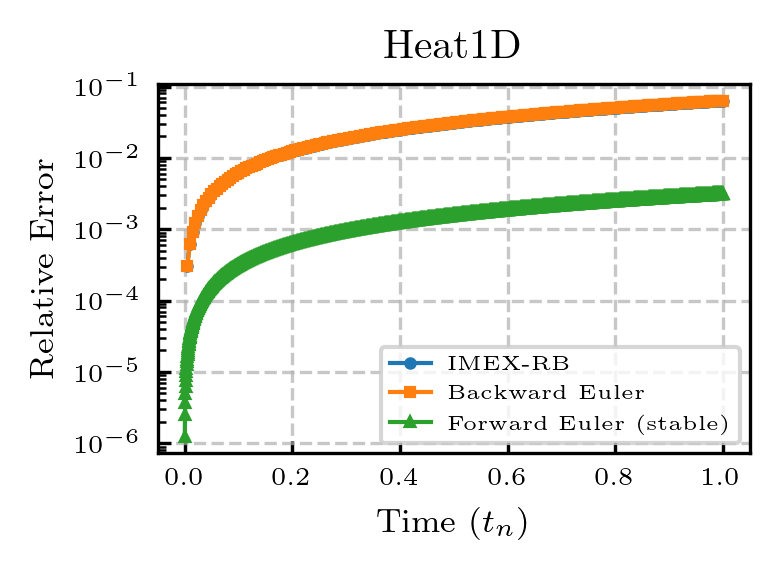

In [8]:
import matplotlib.pyplot as plt

# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem.domain, problem.exact_solution)
errBE = compute_errors(uBE, tvec, problem.domain, problem.exact_solution)
errFE = compute_errors(uFE, tvecFE, problem.domain, problem.exact_solution)

# Plot the errors
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='s')
plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

# Add labels, legend, and title
plt.xlabel(r"Time $(t_n)$")
plt.ylabel("Relative Error")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

In [9]:
# %matplotlib ipympl
# from IPython import display
# import time

# fig, ax = plt.subplots(1, 1)
# hdisplay = display.display("", display_id=True)

# # Set axis labels and limits
# ax.set_ylim(0, 1)
# ax.set_xlim(problem.domain[0], problem.domain[-1])
# ax.set_xlabel("Position (x)")
# ax.set_ylabel("Solution")

# # Initialize the line obj
# line_imex, = ax.plot([], [], "black", label="IMEX-RB")
# line_be, = ax.plot([], [], "red", linestyle="--", label="Backward Euler")
# ax.legend()

# for n, t in enumerate(tvec):
#     line_imex.set_data(problem.domain, uIMEX[:, n])  
#     line_be.set_data(problem.domain, uBE[:, n])      
#     hdisplay.update(fig)
#     # time.sleep(0.001)

# plt.close(fig)


Go back to `matplotlib inline` (after animation)

In [10]:
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

In [11]:
# We now run a convergence test and plot the results
# Define the range of Nt values
Nt_values = [2**n for n in range(2, 12)]
errors_imex = []
errors_be = []
# errors_fe = []

Nt_FE_stable = compute_steps_stability_FE(problem, tspan)
# Loop over Nt values
for Nt in Nt_values:
    # Time discretization
    tvec = np.linspace(t0, tf, Nt + 1)
    dt = tvec[1] - tvec[0]

    # Solve the problem with each scheme
    uIMEX, *_ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    uBE, *_ = backward_euler(problem, u0, tspan, Nt)
    # uFE, *_ = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time for each scheme
    err_imex = compute_errors(uIMEX, tvec, problem.domain, problem.exact_solution)
    err_be = compute_errors(uBE, tvec, problem.domain, problem.exact_solution)
    # err_fe = compute_errors(uFE, tvec, problem.domain, problem.exact_solution)

    # Store the final error
    errors_imex.append(err_imex[-1])
    errors_be.append(err_be[-1])
    # errors_fe.append(err_fe[-1])



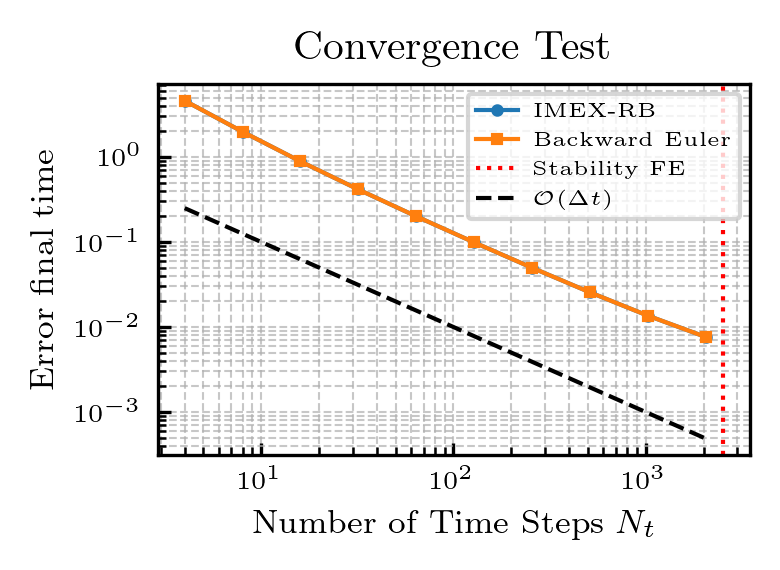

In [12]:
# Plot the convergence results
plt.loglog(Nt_values, errors_imex, label="IMEX-RB", marker='o', linestyle='-')
plt.loglog(Nt_values, errors_be, label="Backward Euler", marker='s', linestyle='-')
# plt.loglog(Nt_values, errors_fe, label="Forward Euler", marker='^', linestyle='-.')
plt.axvline(Nt_FE_stable, label="Stability FE", color="r", linestyle=':') 
plt.loglog(Nt_values, [1/Nt for Nt in Nt_values], label=r"$\mathcal{O}(\Delta t)$", color="k", linestyle='--')
plt.xlabel(r"Number of Time Steps $N_t$")
plt.ylabel("Error final time")
plt.title("Convergence Test")
plt.legend()
plt.grid(True, which="both", linewidth=0.5)
plt.show()

### CPU Time to solution

We now compare the times required by IMEX-RB and BE to obtain a stable solution
N.W.: While we will keep $N_t$ fixed for IMEX-RB and BE, we will compute the $N_t$ making FE stable at each different problem size

In [13]:
# Define number of timesteps
Nt = 200
# Define epsilon for absolute stability condition
epsilon = 1e-4 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(Nx, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

In [17]:
# Parameters for the simulation
kappa = 1.0
bc_left = 0.0
bc_right = 0.0
tspan = [0.0, 1.0]
Nt = 200           # Number of time steps for IMEX and BE

# Lists to store CPU times and errors
Nx_list = []
CPU_IMEX_list = []
CPU_BE_list = []
CPU_FE_list = []

err_IMEX_list = []
err_BE_list = []
err_FE_list = []

# Loop over different spatial resolutions
Nx_values = [2**val for val in range(4, 10)]
for Nx in Nx_values:
    Nx_list.append(Nx)
    print(f"Running simulation for Nx = {Nx}")

    # Define the problem for the current Nx (assumes a Heat1D class exists)
    problem = Heat1D(Nx, L, kappa, bc_left, bc_right)
    u0 = problem.initial_condition()
    epsilon = 1e-4  # tolerance parameter
    maxsize = int(np.ceil(np.power(Nx, 1/3)))
    maxsubiter = maxsize

    # Run IMEX-RB integration
    uIMEX, tvec, subiter, CPUtimeIMEX = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    # Run Backward Euler integration
    uBE, _, CPUTimeBE = backward_euler(problem, u0, tspan, Nt)
    # Run Forward Euler integration on its own stable time grid
    Nt_FE = compute_steps_stability_FE(problem, tspan)
    uFE, tvec_FE, CPUTimeFE = forward_euler(problem, u0, tspan, Nt_FE)

    # Compute errors at final time
    err_IMEX = compute_errors(uIMEX, tvec, problem.domain, problem.exact_solution, finaltimeonly=True)
    err_BE = compute_errors(uBE, tvec, problem.domain, problem.exact_solution, finaltimeonly=True)
    err_FE = compute_errors(uFE, tvec_FE, problem.domain, problem.exact_solution, finaltimeonly=True)

    # Append CPU times and errors
    CPU_IMEX_list.append(CPUtimeIMEX)
    CPU_BE_list.append(CPUTimeBE)
    CPU_FE_list.append(CPUTimeFE)

    err_IMEX_list.append(err_IMEX)
    err_BE_list.append(err_BE)
    err_FE_list.append(err_FE)


Running simulation for Nx = 16
Running simulation for Nx = 32
Running simulation for Nx = 64
Running simulation for Nx = 128
Running simulation for Nx = 256


KeyboardInterrupt: 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

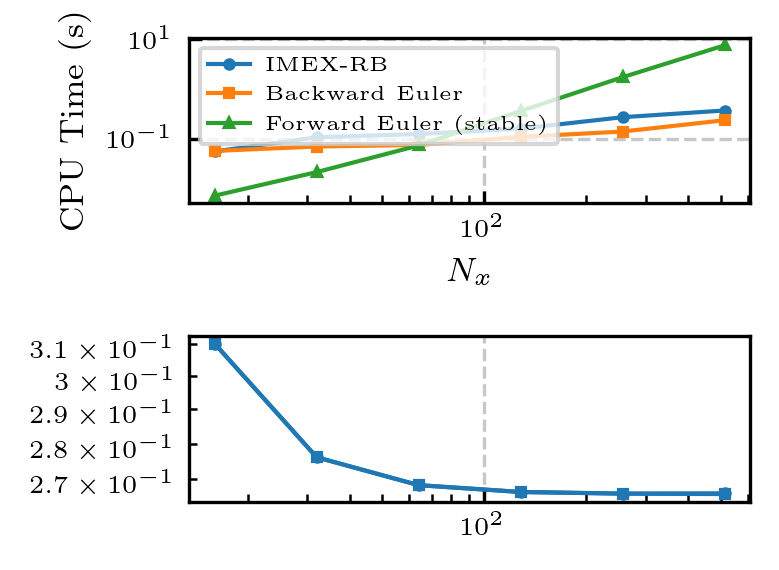

In [15]:
# Plotting CPU times vs Nx
plt.subplot(2, 1, 1)
plt.loglog(Nx_list, CPU_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nx_list, CPU_BE_list, 's-', label='Backward Euler')
plt.loglog(Nx_list, CPU_FE_list, '^-', label='Forward Euler (stable)')
plt.xlabel(r'$N_x$')
plt.ylabel('CPU Time (s)')
# plt.title('CPU Time vs Spatial Resolution')
plt.legend()
plt.grid(True)

# Plotting errors at final time vs Nx
plt.subplot(2, 1, 2)
plt.loglog(Nx_list, err_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nx_list, err_BE_list, 's-', label='Backward Euler')
plt.loglog(Nx_list, err_FE_list, '^-', label='Forward Euler')
plt.xlabel(r'$N_x$')
plt.ylabel(r'Error')
# plt.title('Error vs num of unknowns')
plt.legend()
plt.grid(True)

# plt.tight_layout()
plt.show()

In [16]:
err_FE_list

[array([0.06581426, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  